<a href="https://colab.research.google.com/github/bipin2295/FastAI-Part2/blob/master/01_matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Get Data**

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'


In [3]:
path = datasets.download_data(url=MNIST_URL, ext='.gz');
path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
  ((x_train, y_train),(x_valid, y_valid), _) = pickle.load(f,encoding='latin1')#https://stackoverflow.com/questions/11305790/pickle-incompatibility-of-numpy-arrays-between-python-2-and-3
  

In [0]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n,c = x_train.shape

In [6]:
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
assert n==y_train.shape[0]==50000

In [8]:
print(f"current cmap property : {mpl.rcParams['image.cmap']}")
mpl.rcParams['image.cmap']='gray'
print(f"new cmap property : {mpl.rcParams['image.cmap']}")

current cmap property : viridis
new cmap property : gray


In [0]:
img = x_train[0]

In [10]:
img.view(28,28).type()

'torch.FloatTensor'

Number : 5


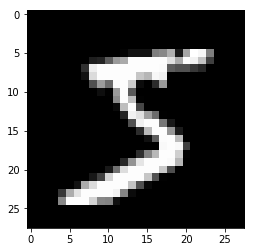

In [11]:
plt.imshow(img.view(28,28)) 
print (f"Number : {y_train[0]}")

# **Initial Python Model**

In [0]:
weights = torch.randn(784,10)
bias = torch.zeros(10)

### Matrix Multiplication

#### Using Simple loops

In [0]:
def matmul(a,b):
  ar,ac = a.shape
  br,bc = b.shape
  assert ac == br
  c = torch.zeros(ar,bc)
  for i in range(ar):
    for j in range(bc):
      for k in range(ar):
        c[i,j] += a[i,k]* b[k,j]
  return c        

In [0]:
m1 =  x_valid[:5,:]
m2 = weights

In [24]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [27]:
%time t1 = matmul(m1,m2)

CPU times: user 6.56 ms, sys: 522 µs, total: 7.08 ms
Wall time: 7.88 ms


Note the speed, it's ~8 ms for 784 columns. It's too slow

In [29]:
t1.shape

torch.Size([5, 10])

#### Using Elementwise operators

In [0]:
def matmul(a,b):
  ar,ac = a.shape
  br,bc = b.shape
  assert ac == br
  c = torch.zeros(ar,bc)
  for i in range(ar):
    for j in range(bc):
      #Note that we removed one loop and used * operator to multiply row and column 
      c[i,j] = (a[i,:] * b[:,j]).sum()
  return c

In [42]:
%timeit -n 10 _ = matmul(m1,m2)

10 loops, best of 3: 1.32 ms per loop


Note that time has reduced to 1.32 ms, which is 8 times less.

#### Using Broadcasting:
The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations. The term broadcasting was first used by Numpy.

From the Numpy Documentation:



```
The term broadcasting describes how numpy treats arrays with 
different shapes during arithmetic operations. Subject to certain 
constraints, the smaller array is “broadcast” across the larger 
array so that they have compatible shapes. Broadcasting provides a 
means of vectorizing array operations so that looping occurs in C
instead of Python. It does this without making needless copies of 
data and usually leads to efficient algorithm implementations.
```




#### Broadcasting with scalar

In [43]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [44]:
a>0

tensor([1, 1, 0], dtype=torch.uint8)

How are we able to do a > 0? 0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [45]:
a-1 #Broadcasting scalar to matrix

tensor([ 9.,  5., -5.])

In [49]:
m = tensor([[1., 2, 3],
           [4, 5, 6],
           [7, 8, 9]])
m, type(m)

(tensor([[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]), torch.Tensor)

In [50]:
2*m   #

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

In [59]:
c = tensor([10.,20.,30.]);c

tensor([10., 20., 30.])

In [60]:
m+c   #Broadcasting vector to a matrix

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [62]:
# To see how it actually looks like,
t = c.expand_as(m); t; t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [63]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use unsqueeze() to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [67]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [68]:
 c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [72]:
 c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape  #Use unsqueeze to convert the dimension

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [73]:
c.shape, c[None].shape,c[:,None].shape   # Use None value to convert the dimension

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

#### Matrix multiplication with Broadcasting

In [0]:
def matmul(a,b):
  ar,ac = a.shape
  br,bc = b.shape
  assert ac == br
  c = torch.zeros(ar,bc)
  for i in range(ar):
#     c[i,j] = (a[i,:]* b[:,j]).sum() # previous
    c[i] = a[i,:]

In [85]:
m2[1].unsqueeze(1)

tensor([[ 1.7380],
        [ 0.8622],
        [ 1.1186],
        [ 1.3262],
        [-1.5371],
        [ 0.2526],
        [-0.9539],
        [-0.6528],
        [-0.1980],
        [-0.6856]])

In [87]:
m2[None,1]

tensor([[ 1.7380,  0.8622,  1.1186,  1.3262, -1.5371,  0.2526, -0.9539, -0.6528,
         -0.1980, -0.6856]])